In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch

import matplotlib.pyplot as plt


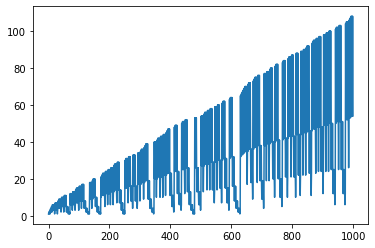

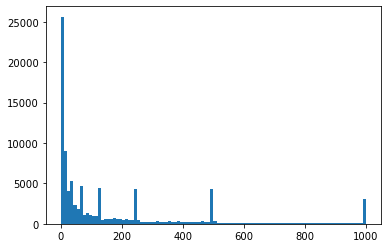

In [2]:
#Return 1d numpy array of block accesses for experiemt_number
def read_experiment_result(experiment_number):
    path = "exp_results/" + str(experiment_number) + ".csv"
    with open(path) as file:
        ret = []
        for line in file:
            line = line.split(",")
            for x in line:
                if x != ' ':
                    ret.append(int(x))
        ret = np.asarray(ret)
        return ret



frame = read_experiment_result(12)
plt.plot(frame[:1000])
plt.show()

plt.hist(frame, 100)
plt.show()

series = torch.from_numpy(frame)
train_series = series[:1000]
validation_series = series[1000:1400]
test_series = series[1400:2000]



In [3]:
class fs_net(nn.Module):
    
    def __init__(self, num_layers, hidden_dim):
        super().__init__()
        
        self.input_dim = 1 #The input for each time step is a scalar
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim #Dimension of the Hidden State and the Cell State
        self.lstm_layer = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
        
        self.linear_layer = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        output, (hidden_state, cell_state) = self.lstm_layer(x)
        x = hidden_state[-1]
        #use a linear layer to take the last hidden output and produce a scalar value from it
        x = self.linear_layer(x)
        return x

In [4]:
def make_batched_data(data, batch_size, previous_steps):
    ret_input = []
    ret_output = []
    n = data.shape[0]
    for i in range(previous_steps, n):
        previous_data = data[i - previous_steps:i]
        ret_input.append(previous_data)
        curr_data = data[i]
        ret_output.append(curr_data)
    
    ret_input_batched = []
    ret_output_batched = []
    index = 0
    while(index < len(ret_input)):
        data_point_input = torch.randn(batch_size, previous_steps)
        data_point_output = torch.randn(batch_size)
        offset = 0
        while(index + offset < len(ret_input) and offset < batch_size):
            data_point_input[offset] = ret_input[index + offset]
            data_point_output[offset] = ret_output[index + offset]
            offset += 1
        
        ret_input_batched.append(data_point_input)
        ret_output_batched.append(data_point_output)
        index += offset
            
    return ret_input_batched, ret_output_batched

In [11]:
def train(myNet, train_data, validation_data, batch_size, num_epochs, num_previous_blocks, learning_rate):

    train_inputs, train_outputs = make_batched_data(train_data, batch_size, num_previous_blocks)
    train_inputs = [torch.unsqueeze(T, -1) for T in train_inputs]
    train_outputs = [T.reshape(batch_size,1) for T in train_outputs]
    
    val_inputs, val_outputs = make_batched_data(validation_data, 1, num_previous_blocks)
    val_inputs = [torch.unsqueeze(T, -1) for T in val_inputs]
    val_outputs = [T.reshape(1,1) for T in val_outputs]
    
    criterion = nn.MSELoss()
    optimizer = optim.SGD(myNet.parameters(), lr=learning_rate, momentum=.09)
    
    training_losses = []
    validation_losses = []
    for i in range(num_epochs):
        total_loss = 0
        for j in range(len(train_inputs)):
            optimizer.zero_grad()
            pred = myNet(train_inputs[j])
            truth = train_outputs[j]
            loss = criterion(pred, truth)
            loss.backward()
            optimizer.step()
            total_loss += loss
        if(i > 0 and i%5 == 0):
            print("Average Loss for epoch " + str(i) + ": " + str(total_loss.item()/float(len(train_inputs))))
        training_losses.append(total_loss.item()/float(len(train_inputs)))
        
        val_loss = 0
        for j in range(len(val_inputs)):
            pred = myNet(val_inputs[j])
            truth = val_outputs[j]
            loss = criterion(pred, truth)
            val_loss += loss
        if(i > 0 and i%5 == 0):
            print("Average Validation loss for epoch " + str(i) + ": " + str(val_loss.item()/float(len(val_inputs))))
        validation_losses.append(val_loss.item()/float(len(val_inputs)))
    
    plt.plot(training_losses, label="Training losses")
    plt.plot(validation_losses, label="Validation losses")
    plt.title("Losses on Training and Validation as a function of Epoch")
    plt.legend()
    plt.show()
    
    return validation_losses[-1]
    
#Returns validation loss of the trained model
def do_experiment(hidden_dims, num_previous_blocks, num_layers, num_epochs, batch_size, learning_rate, show=False):    

    test_inputs, test_outputs = make_batched_data(test_series, 1, num_previous_blocks)
    test_inputs = [torch.unsqueeze(T, -1) for T in test_inputs]
    test_outputs = [T.reshape(1,1) for T in test_outputs]
    
    
    net = fs_net(num_layers, hidden_dims)
    ret1 = train(net, 
          train_series, 
          validation_series, 
          batch_size=batch_size, 
          num_epochs=num_epochs, 
          num_previous_blocks=num_previous_blocks,
          learning_rate=learning_rate)

    if(show):
        preds = [net(test_inputs[i]) for i in range(len(test_inputs))]
        criterion = nn.MSELoss()
        test_loss = 0
        for i in range(len(test_outputs)):
            test_loss += criterion(test_outputs[i], preds[i].unsqueeze(-1))
        print("Average MSE Loss on the test data: " + str( test_loss.item()/float(len(preds))))
        print(preds)
        preds = [x.item() for x in preds]
        plt.title("Prediction for blocks on Test Data Set with hidden Neurons = " + str(hidden_dims))
        plt.plot(preds, label="Predictions")
        plt.plot(test_outputs, label="Actual")
        plt.xlabel("Access Number")
        plt.ylabel("Block")
        plt.legend()
        plt.show()
    
    return ret1

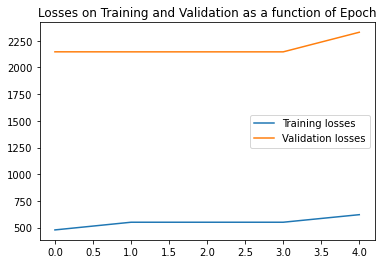

Average MSE Loss on the test data: 4690.647881355932
[tensor([[87.4569]], grad_fn=<AddmmBackward>), tensor([[87.4569]], grad_fn=<AddmmBackward>), tensor([[87.4569]], grad_fn=<AddmmBackward>), tensor([[87.4569]], grad_fn=<AddmmBackward>), tensor([[87.4569]], grad_fn=<AddmmBackward>), tensor([[87.4568]], grad_fn=<AddmmBackward>), tensor([[87.4569]], grad_fn=<AddmmBackward>), tensor([[87.4569]], grad_fn=<AddmmBackward>), tensor([[87.4568]], grad_fn=<AddmmBackward>), tensor([[87.4569]], grad_fn=<AddmmBackward>), tensor([[87.4568]], grad_fn=<AddmmBackward>), tensor([[87.4566]], grad_fn=<AddmmBackward>), tensor([[87.4567]], grad_fn=<AddmmBackward>), tensor([[87.4567]], grad_fn=<AddmmBackward>), tensor([[87.4566]], grad_fn=<AddmmBackward>), tensor([[87.4567]], grad_fn=<AddmmBackward>), tensor([[87.4566]], grad_fn=<AddmmBackward>), tensor([[87.4563]], grad_fn=<AddmmBackward>), tensor([[87.4565]], grad_fn=<AddmmBackward>), tensor([[87.4569]], grad_fn=<AddmmBackward>), tensor([[87.4569]], grad_f

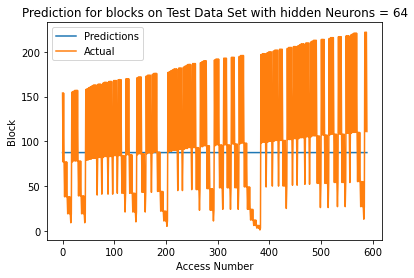

2329.39983974359

In [12]:
do_experiment(hidden_dims=64, 
              num_previous_blocks=10, 
              num_layers=2, 
              num_epochs=5, 
              batch_size=10, 
              learning_rate=.15,
              show=True)